In [1]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:

# Set a seed for reproducibility
np.random.seed(0)

# Read in the data
data =pd.read_csv('diabetes_prediction_dataset.csv')
print(data.duplicated())
print(data.duplicated().sum())

# dropped dupliccates
data.drop_duplicates(inplace=True)



sample_df = data.sample(n=30000, random_state=42)


# categorise features into numeric and non numeric
numeric_col = []
non_numeric_col = []
for column in data.columns:
    if pd.api.types.is_numeric_dtype(data[column]):
        if data[column].nunique() < 5:
            non_numeric_col.append(column)
        else:
            numeric_col.append(column)
    else:
        non_numeric_col.append(column)


# Label Encoder
class CustomLabelEncoder:
    def __init__(self):
        self.mapping = {}

    def fit(self, data):
        unique_values = set(data)
        self.mapping = {value: index for index, value in enumerate(unique_values)}

    def transform(self, data):
        return [self.mapping[value] for value in data]

# Encoding non-numeric columns
for col in non_numeric_col:
    label_encoder = CustomLabelEncoder()
    label_encoder.fit(sample_df[col])
    sample_df[col] = label_encoder.transform(sample_df[col])




0        False
1        False
2        False
3        False
4        False
         ...  
99995     True
99996    False
99997    False
99998    False
99999    False
Length: 100000, dtype: bool
3854


In [3]:

# Splitting into train, validation and test data
def custom_train_validation_test_split(x, y, test_size=0.2, validation_size=0.2, random_state=None):
    np.random.seed(random_state)
    indices = np.arange(len(x))
    np.random.shuffle(indices)

    test_size = int(test_size * len(x))
    validation_size = int(validation_size * len(x))

    test_indices = indices[:test_size]
    validation_indices = indices[test_size:(test_size + validation_size)]
    train_indices = indices[(test_size + validation_size):]

    x_train, x_val, x_test = x.iloc[train_indices], x.iloc[validation_indices], x.iloc[test_indices]
    y_train, y_val, y_test = y.iloc[train_indices], y.iloc[validation_indices], y.iloc[test_indices]

    return x_train, x_val, x_test, y_train, y_val, y_test


# Use the resampled data for splitting
X_train, X_valid, X_test, y_train, y_valid, y_test = custom_train_validation_test_split(
    sample_df.drop('diabetes', axis=1),
    sample_df['diabetes'],
    test_size=0.2,
    validation_size=0.2,
    random_state=42
)


In [4]:

# Standardize the features
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std

# class-specific means for projection
mean_class_0 = X_train[y_train == 0].mean(axis=0)
mean_class_1 = X_train[y_train == 1].mean(axis=0)

#  scatter matrix
scatter_class_0 = np.cov(X_train[y_train == 0], rowvar=False)
scatter_class_1 = np.cov(X_train[y_train == 1], rowvar=False)

# optimal projection direction
S_W = scatter_class_0 + scatter_class_1
w_optimal = np.linalg.inv(S_W).dot(mean_class_1 - mean_class_0)
print(w_optimal)

# Project the validation data
X_valid_projected = np.matmul(X_valid, w_optimal)
# print(X_valid_projected)

# Classify each validation sample
y_pred = np.where(X_valid_projected >= 0, 1, 0)


[-0.08517853  0.57766484  0.10173336  0.09838422  0.00898818  0.31930373
  0.80964551  0.55831745]


Accuracy for LDA: 0.6120
              precision    recall  f1-score   support

           0       1.00      0.58      0.73      5473
           1       0.18      0.99      0.31       527

    accuracy                           0.61      6000
   macro avg       0.59      0.78      0.52      6000
weighted avg       0.93      0.61      0.69      6000



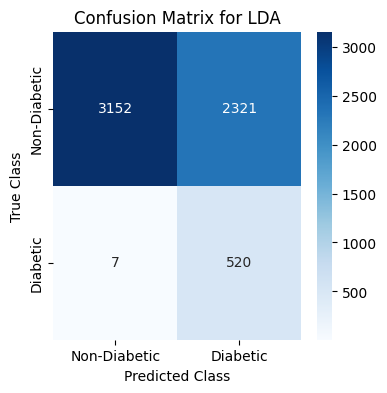

--------------------------------------------------------


In [5]:

conf_matrix = confusion_matrix(y_valid, y_pred)
accuracy = np.trace(conf_matrix) / float(np.sum(conf_matrix))

print(f"Accuracy for LDA: {accuracy:.4f}")
print(classification_report(y_valid, y_pred))

# Plotting Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    xticklabels=["Non-Diabetic", "Diabetic"],
    yticklabels=["Non-Diabetic", "Diabetic"],
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title(f"Confusion Matrix for LDA")
plt.show()

print("--------------------------------------------------------")